In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

df_d = pd.read_csv('d.csv')
df_si = pd.read_csv('si.csv')
df_ge = pd.read_csv('ge.csv')
# Drop 'Unnamed: 0' column if it exists
df_d.drop(columns=[col for col in df_d.columns if 'Unnamed' in col], inplace=True)
df_si.drop(columns=[col for col in df_si.columns if 'Unnamed' in col], inplace=True)
df_ge.drop(columns=[col for col in df_ge.columns if 'Unnamed' in col], inplace=True)
df_d.dropna(inplace=True)
df_d = df_d.rename(columns={"λ (nm)": "lambda_nm", "D(λ)": "D"})
df_si = df_si.rename(columns={"λ (nm)": "lambda_nm", "λ (µm)": "lambda_um", "U (mV)": "U_mV"})
df_ge = df_ge.rename(columns={"λ (nm)": "lambda_nm", "λ (µm)": "lambda_um", "U (V)": "U_mV"})

print(df_d.head())
print(df_si.head())
print(df_ge.head())



   lambda_nm      D
0     1000.0  158.0
1     1100.0  140.0
2     1150.0  135.0
3     1250.0  125.0
4     1350.0  120.0
   lambda_um  lambda_nm  U_mV
0      0.700        700  0.90
1      0.750        750  1.35
2      0.800        800  1.80
3      0.821        821  2.10
4      0.852        852  2.70
   lambda_um  lambda_nm  U_mV
0       0.88      880.0  0.93
1       0.90      900.0  1.23
2       0.92      920.0  1.56
3       0.94      940.0  2.01
4       0.96      960.0  2.40


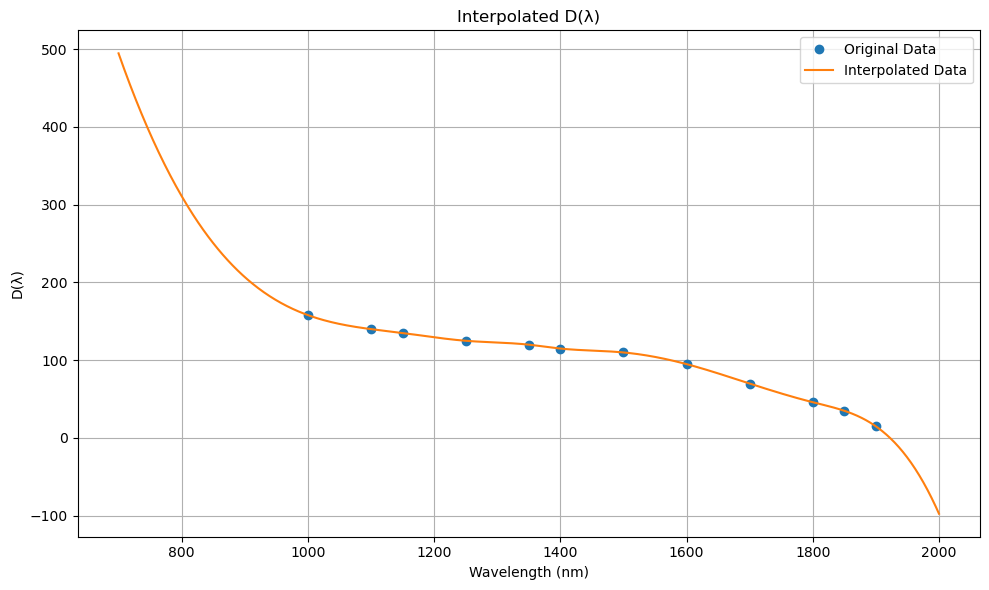

   lambda_um  lambda_nm  U_mV           D         S         E
0      0.700        700  0.90  494.550025  0.000002  1.772429
1      0.750        750  1.35  391.319461  0.000003  1.654267
2      0.800        800  1.80  310.991676  0.000006  1.550875
3      0.821        821  2.10  283.353453  0.000007  1.511206
4      0.852        852  2.70  248.483147  0.000011  1.456221
   lambda_um  lambda_nm  U_mV           D         S         E
0       0.88      880.0  0.93  222.528603  0.000004  1.409886
1       0.90      900.0  1.23  206.902780  0.000006  1.378556
2       0.92      920.0  1.56  193.484402  0.000008  1.348587
3       0.94      940.0  2.01  182.079201  0.000011  1.319894
4       0.96      960.0  2.40  172.492912  0.000014  1.292396


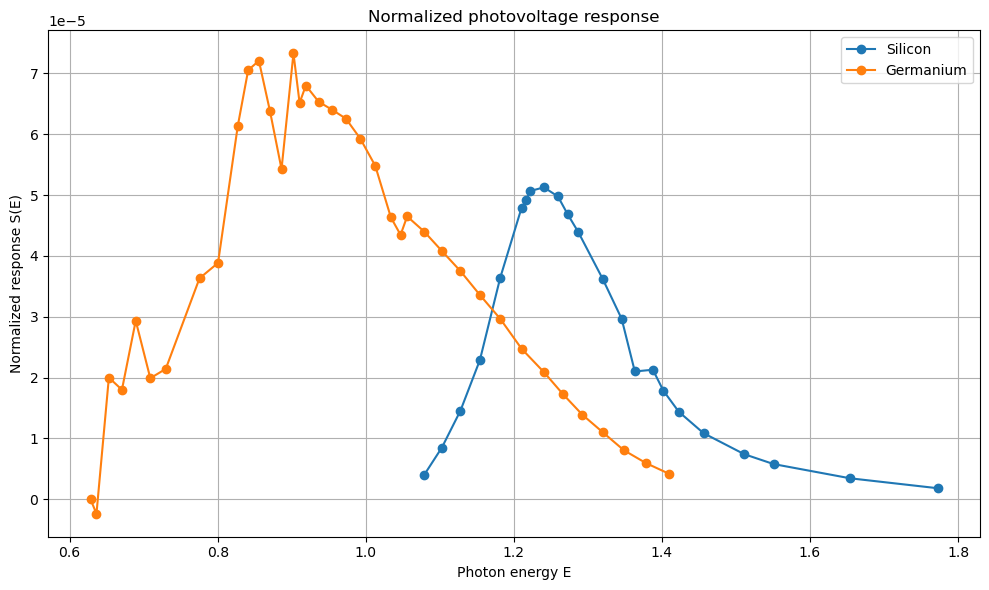

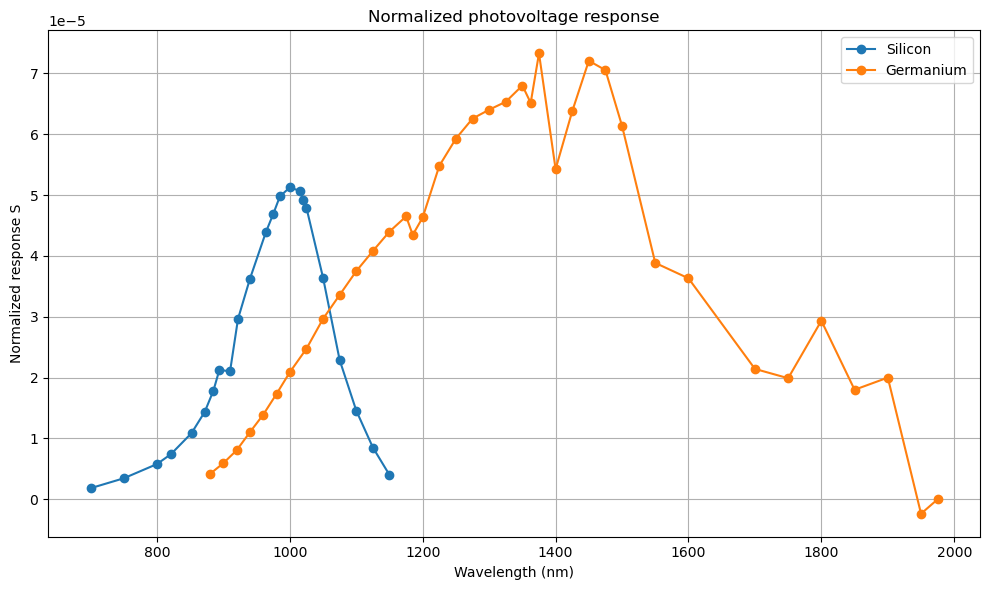

In [2]:
#D interpolation
D_interp_updated = interp1d(df_d["lambda_nm"], df_d["D"], kind="cubic", bounds_error=False, fill_value="extrapolate")
# plot interpolated D
lambda_nm_interp = np.linspace(df_si["lambda_nm"].min(), 2000, 1000)
D_interp = D_interp_updated(lambda_nm_interp)
plt.figure(figsize=(10, 6))
plt.plot(df_d["lambda_nm"], df_d["D"], 'o', label='Original Data')
plt.plot(lambda_nm_interp, D_interp, '-', label='Interpolated Data')
plt.xlabel("Wavelength (nm)")
plt.ylabel("D(λ)")
plt.title("Interpolated D(λ)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df_si["D"] = D_interp_updated(df_si["lambda_nm"])
df_ge["D"] = D_interp_updated(df_ge["lambda_nm"])

df_si["S"] = df_si["U_mV"] * 1e-3/ df_si["D"]
df_ge["S"] = df_ge["U_mV"] * 1e-3/ df_ge["D"]
df_si["E"] = 1240.7 / df_si["lambda_nm"]
df_ge["E"] = 1240.7 / df_ge["lambda_nm"]

print(df_si.head())
print(df_ge.head())

plt.figure(figsize=(10, 6))
plt.plot(df_si["E"], df_si["S"], 'o-', label='Silicon')
plt.plot(df_ge["E"], df_ge["S"], 'o-', label='Germanium')
plt.xlabel("Photon energy E")
plt.ylabel("Normalized response S(E)")
plt.title("Normalized photovoltage response")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#plot s vs lambda
plt.figure(figsize=(10, 6))
plt.plot(df_si["lambda_nm"], df_si["S"], 'o-', label='Silicon')
plt.plot(df_ge["lambda_nm"], df_ge["S"], 'o-', label='Germanium')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized response S")
plt.title("Normalized photovoltage response")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

{'Silicon Eg': '1.075 ± 0.014 eV', 'Germanium Eg': '0.637 ± 0.013 eV'}
Eg_si_poly: 1.075010006604719
Eg_ge_poly: 0.6367092164254047


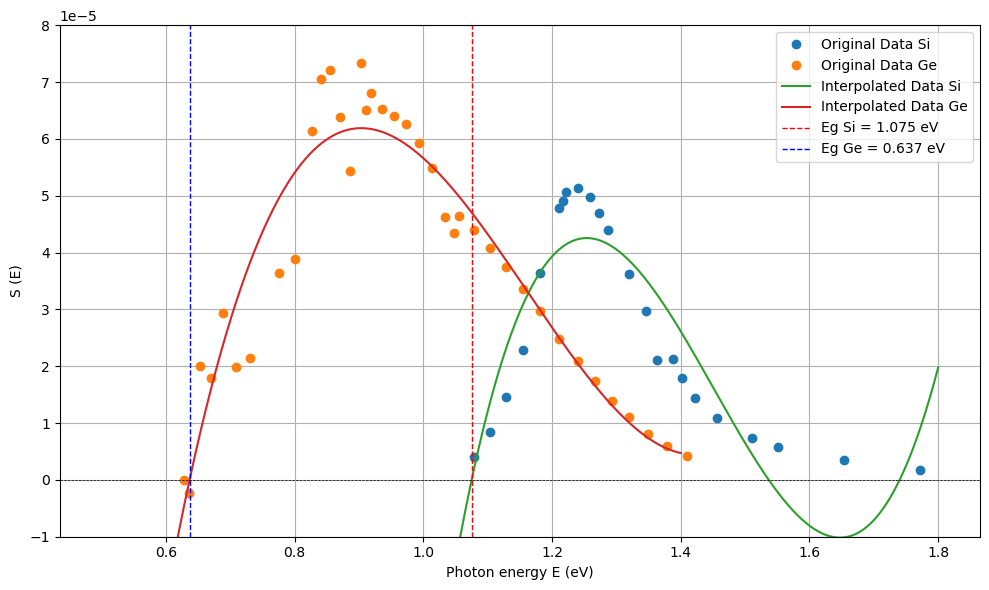

In [4]:
#interpolate silicon and germanium data by cubic polynomial
# Fit a fourth-order polynomial to the silicon and germanium data
# Fit a fourth-order polynomial to the silicon and germanium data within a specific range
si_fit_range = (df_si["E"] >= 0.4) & (df_si["E"] <= 2)
ge_fit_range = (df_ge["E"] >= 0.5) & (df_ge["E"] <= 2)

si_poly_coeffs = np.polyfit(df_si["E"][si_fit_range], df_si["S"][si_fit_range], 3)
ge_poly_coeffs = np.polyfit(df_ge["E"][ge_fit_range], df_ge["S"][ge_fit_range], 3)

# Create polynomial functions
si_interp_updated = np.poly1d(si_poly_coeffs)
ge_interp_updated = np.poly1d(ge_poly_coeffs)
E_si_interp = np.linspace(0.5, 1.8, 1000)
E_ge_interp = np.linspace(0.5, 1.4, 1000)



roots_si = np.roots(si_poly_coeffs)
roots_ge = np.roots(ge_poly_coeffs)

Eg_si_poly = np.real(roots_si[(np.isreal(roots_si)) & (roots_si > 0.9) & (roots_si < 1.2)])[0]
Eg_ge_poly = np.real(roots_ge[(np.isreal(roots_ge)) & (roots_ge > 0.5) & (roots_ge < 0.8)])[0]


# Fix the derivative evaluation error
def estimate_uncertainty_fixed(E, S, coeffs, Eg):
    y_fit = np.polyval(coeffs, E)
    residuals = S - y_fit
    std_res = np.std(residuals)
    dpoly = np.poly1d(np.polyder(coeffs))
    dS_dE = dpoly(Eg)
    dEg = std_res / abs(dS_dE)
    return dEg

# Recalculate with fixed function
dEg_si = estimate_uncertainty_fixed(df_si["E"][si_fit_range], df_si["S"][si_fit_range], si_poly_coeffs, Eg_si_poly)
dEg_ge = estimate_uncertainty_fixed(df_ge["E"][ge_fit_range], df_ge["S"][ge_fit_range], ge_poly_coeffs, Eg_ge_poly)

# Final values with uncertainties
print({
    "Silicon Eg": f"{Eg_si_poly:.3f} ± {dEg_si:.3f} eV",
    "Germanium Eg": f"{Eg_ge_poly:.3f} ± {dEg_ge:.3f} eV"
})

print("Eg_si_poly:", Eg_si_poly)
print("Eg_ge_poly:", Eg_ge_poly)

plt.figure(figsize=(10, 6))
plt.plot(df_si["E"], df_si["S"], 'o', label='Original Data Si')
plt.plot(df_ge["E"], df_ge["S"], 'o', label='Original Data Ge')
plt.plot(E_si_interp, si_interp_updated(E_si_interp), '-', label='Interpolated Data Si')
plt.plot(E_ge_interp, ge_interp_updated(E_ge_interp), '-', label='Interpolated Data Ge')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(Eg_si_poly, color='red', lw=1, ls='--', label=f"Eg Si = {Eg_si_poly:.3f} eV")
plt.axvline(Eg_ge_poly, color='blue', lw=1, ls='--', label=f'Eg Ge = {Eg_ge_poly:.3f} eV')
plt.xlabel("Photon energy E (eV)")
plt.ylabel("S (E)")
#plt.title("Interpolated S")
plt.ylim(-1e-5, 8e-5)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

#find intersection with x-axis


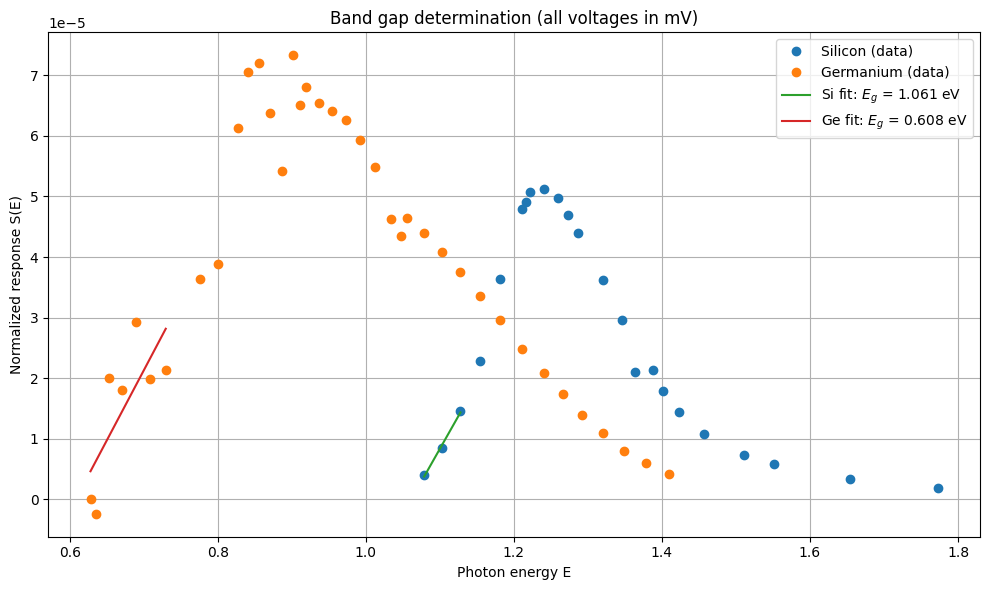

(np.float64(1.0613702652601966), np.float64(0.6080945858840455))

In [28]:
# Recalculate assuming all voltages are in mV and should be converted to V × gain(3)
from scipy.stats import linregress

def bandgap_fit(df, E_range):
    df_fit = df[(df["E"] >= E_range[0]) & (df["E"] <= E_range[1])]
    slope, intercept, _, _, _ = linregress(df_fit["E"], df_fit["S"])
    Eg = -intercept / slope
    return Eg, slope, intercept, df_fit

# Re-run fit for Ge
Eg_ge_corr, slope_ge_corr, intercept_ge_corr, df_fit_ge_corr = bandgap_fit(df_ge, E_range=(0.60, 0.75))
Eg_si, slope_si, intercept_si, df_fit_si = bandgap_fit(df_si, E_range=(1.00, 1.15))


# Update plot
plt.figure(figsize=(10, 6))
plt.plot(df_si["E"], df_si["S"], 'o', label='Silicon (data)')
plt.plot(df_ge["E"], df_ge["S"], 'o', label='Germanium (data)')

plt.plot(df_fit_si["E"], slope_si * df_fit_si["E"] + intercept_si,
         '-', label=f'Si fit: $E_g$ = {Eg_si:.3f} eV')
plt.plot(df_fit_ge_corr["E"], slope_ge_corr * df_fit_ge_corr["E"] + intercept_ge_corr,
         '-', label=f'Ge fit: $E_g$ = {Eg_ge_corr:.3f} eV')

plt.xlabel("Photon energy E")
plt.ylabel("Normalized response S(E)")
plt.title("Band gap determination (all voltages in mV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Eg_si, Eg_ge_corr


In [6]:
# Convert DataFrame to LaTeX table
def df_to_latex(df, filename):
    with open(filename, 'w') as f:
        f.write(df.to_latex(index=False, float_format="%.3f"))
    print(f"Table saved to {filename}")

# Save both silicon and germanium data to LaTeX tables
df_to_latex(df_si, "si_table.tex")
df_to_latex(df_ge, "ge_table.tex")

Table saved to si_table.tex
Table saved to ge_table.tex
